In [ ]:
##import
import pandas as pd
import numpy as np
from IPython.core.display import display
from tqdm import tqdm_notebook as tqdm
from copy import deepcopy as cp

##visualization
from ipywidgets import interact
from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from bokeh.layouts import gridplot
from bokeh.palettes import Category10 as palette
from bokeh.resources import INLINE
output_notebook(resources=INLINE)
import itertools

##import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, average_precision_score, auc
from sklearn.feature_selection import SelectKBest, f_classif

## statistical visualization
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def showCurves(recalls, precisions, fprs, tprs):
    ##make figure
    s1 = figure(
        title = "PR曲線", 
        plot_width=300, plot_height=300,
        x_range=(-0.02,1.02), y_range=(0,1.02)
    )

    s2 = figure(
        title = "ROC曲線", 
        plot_width=300, plot_height=300,
        x_range=(-0.02,1.02), y_range=(0,1.02)
    )

    colors = palette[10]  

    for i in tqdm(range(len(recalls))):

        ##add line
        s1.line(
            recalls[i],
            precisions[i],
            line_width = 1,
            color=colors[i]
        )

        ##add line
        s2.line(
            fprs[i],
            tprs[i],
            line_width = 1,
            color=colors[i]
        )


    s1.xaxis.axis_label = 'Recall'
    s1.yaxis.axis_label = 'Precision'

    s2.xaxis.axis_label = 'FPR'
    s2.yaxis.axis_label = 'TPR'

    p = gridplot([[s1, s2]])

    show(p)
    
def getMeans(recalls, precisions, fprs, tprs):
    tprs_ = []
    precisions_=[]
    ##リスト型は関数内での操作であっても参照先が変更されてしまうので演算用につくった
    mean_fpr = np.linspace(0, 1, 100)
    mean_recall = np.linspace(0, 1, 100)
    for i in range(len(recalls)):
        tprs_.append( np.interp(mean_fpr, fprs[i], tprs[i]) )#tprの線形補間
        precisions_.append( np.interp(mean_recall, recalls[i][::-1], precisions[i][::-1]))
        ##recallが1から返されてるので逆順に行列をいれて上げないとバグる
    mean_tpr = np.mean(tprs_, axis=0)
    mean_precision = np.mean(precisions_, axis=0)
    
    return mean_recall, mean_precision, mean_fpr, mean_tpr

def showMeanCurve(mean_recall, mean_precision, mean_fpr, mean_tpr):
    ##make figure
    s1 = figure(
        title = "PR曲線", 
        plot_width=300, plot_height=300,
        x_range=(-0.02,1.02), y_range=(0,1.02)
    )

    s2 = figure(
        title = "ROC曲線", 
        plot_width=300, plot_height=300,
        x_range=(-0.02,1.02), y_range=(0,1.02)
    )

    ##add line
    s1.line(
        mean_recall,
        mean_precision,
        line_width = 2
    )

    ##add patch
    s1.patch(
        np.hstack((mean_recall, 1, 0)),
        np.hstack((mean_precision, 0, 0)),
        alpha = 0.1,
    )


    ##add line
    s2.line(
        mean_fpr,
        mean_tpr,
        line_width = 2,

    )

    s2.patch(
        np.hstack((mean_fpr, 1, 0)),
        np.hstack((mean_tpr, 0, 0)),
        alpha = 0.1,

    )

    s1.xaxis.axis_label = 'Recall'
    s1.yaxis.axis_label = 'Precision'

    s2.xaxis.axis_label = 'FPR'
    s2.yaxis.axis_label = 'TPR'

    p = gridplot([[s1, s2]])

    show(p)
    print('PR曲線のAUCスコア:',auc(mean_recall,mean_precision),'\tROC曲線のAUCスコア:',auc(mean_fpr, mean_tpr))

In [ ]:
##acquire data
df = pd.read_csv('./creditcard.csv')
df0 = df[df.Class == 0]
df1 = df[df.Class == 1]
df1.head()

sklearnとborutaによる変数選択を行ってみて、その結果を比較する。
### sklearnの場合
https://qiita.com/rockhopper/items/a68ceb3248f2b3a41c89
https://qiita.com/nazoking@github/items/b9eb61f0c981af2cbdd0
https://qiita.com/ishizakiiii/items/0650723cc2b4eef2c1cf

まずFilter Methodによる変数選択を行ってみます。今回、特徴(説明変数)が連続値で、目的変数がカテゴリーなので、**前回の記事**の表に従うとLDAを用いて、目的変数に対して特徴が効いてるのか見ることになります。がしかし。sklearnで楽にやりたかったこともあり今回はANOVAのF値を指標にしました。これは、sklearn.feature_selection.SelectKBestでf_classif(判別分析用)を指定したときのスコアになります。
ANOVAのF値については、いろいろ検索してみましたがこちらが私的にわかりやすいと感じました。(このF値とF分布を用いると検定の枠組みに持っていくことができて、その特徴がどの程度の確率で有意なのかも定量的に判断することができますが今回は考えないことにします。)http://www.ipc.shimane-u.ac.jp/food/kobayasi/anova.htm

さて、では実際に変数選択してみましょう。

In [ ]:
def filter_features(n):
    #n is a number of features
    X = df.drop('Class', axis=1)
    y = df.Class
    selector = SelectKBest(score_func=f_classif, k=n)
    selector.fit(X, y)
    df_mask = selector.get_support()
    X = X.iloc[:,df_mask]
    df_masked = df.iloc[:,df_mask]
    ##selector.transform(X)でも整形できますがcolumns名が消えます。
    return X, y

def make_dfs(X, y):
    df_new = pd.concat([X,y], axis=1)
    df0_new = df_new[df_new.Class == 0]
    df1_new = df_new[df_new.Class == 1]
    return df_new, df0_new, df1_new

def LR_with_10foldCV(X, y):
    probs=[]
    pr_aucs=[]
    roc_aucs=[]
    fprs=[]
    tprs=[]
    precisions=[]
    recalls=[]

    ## cross validation
    cv = StratifiedKFold(n_splits=10)

    lr = LogisticRegression()
    for train, test in tqdm(cv.split(X,y)): 
        ##インデックス番号の分割をしている。
        ##ロジスティック回帰
        prob = lr.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        probs.append(prob)
        ##ROC曲線
        fpr, tpr, thresholds = roc_curve(y[test], prob[:, 1], pos_label=1)
        fprs.append(fpr)
        tprs.append(tpr)
        roc_aucs.append(auc(fpr, tpr))

        ##PR曲線
        precision, recall, thresholds = precision_recall_curve(y[test], prob[:, 1], pos_label=1)
        precisions.append(precision)
        recalls.append(recall)
        pr_aucs.append(auc(recall, precision))

    showCurves(recalls, precisions, fprs, tprs)
    mean_recall, mean_precision, mean_fpr, mean_tpr = getMeans(recalls, precisions, fprs, tprs)
    showMeanCurve(mean_recall, mean_precision, mean_fpr, mean_tpr)


def RF_with_10foldCV(X, y):
    probs=[]
    pr_aucs=[]
    roc_aucs=[]
    fprs=[]
    tprs=[]
    precisions=[]
    recalls=[]


    random_forest = RandomForestClassifier(n_estimators=10) ##n is decided roughly.

    for train, test in tqdm(cv.split(X,y)): 
        ##インデックス番号の分割をしている。
        ##Random Forest
        prob = random_forest.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])

        probs.append(prob)
        ##ROC曲線
        fpr, tpr, thresholds = roc_curve(y[test], prob[:, 1], pos_label=1)
        fprs.append(fpr)
        tprs.append(tpr)
        roc_aucs.append(auc(fpr, tpr))

        ##PR曲線
        precision, recall, thresholds = precision_recall_curve(y[test], prob[:, 1], pos_label=1)
        precisions.append(precision)
        recalls.append(recall)
        pr_aucs.append(auc(recall, precision))

    showCurves(recalls, precisions, fprs, tprs)
    mean_recall, mean_precision, mean_fpr, mean_tpr = getMeans(recalls, precisions, fprs, tprs)
    showMeanCurve(mean_recall, mean_precision, mean_fpr, mean_tpr)

In [ ]:
X, y = filter_features(1)
df_masked, df0, df1 = make_dfs(X,y)
X.head()

試しに最も目的変数と相関のある変数を抽出してみました。これでどれぐらいの性能のモデルがつくれるか見てみましょう。

In [ ]:
for i in tqdm(range(len(df0.columns)-1)):
    g = sns.distplot(df0.iloc[:,i], color='green')
    g = sns.distplot(df1.iloc[:,i], color='red') 
    plt.show()

LR_with_10foldCV(X, y)
RF_with_10foldCV(X, y)


V17は分布の形が結構異なりますがある程度線形分離できそうな感じです。一つの変数でも結構当たるもんですね。
ランダムフォレストの性能が悪いのはインバランスの影響が大きく効いてると思います。(SMOTEやUnderSamplingを施して学習しなければ性能を期待できない。)

つぎにいくつ特徴を使えばいいのか全探索してみます。(変数選択ではダブルクロスバリデーションを用いないと過学習する可能性があるのですが今回は単純に10-foldCVしたときのAUCスコアだけで評価することにします)

In [ ]:
for i in tqdm(range(1,len(df.columns))):
    print('number of features:', i)
    X, y = filter_features(i)
    LR_with_10foldCV(X, y)    

In [ ]:
for i in tqdm(range(1,len(df.columns))):
    print('number of features:', i)
    X, y = filter_features(i)
    RF_with_10foldCV(X, y)  

ロジスティック回帰における特徴の数とPR-AUCの関係
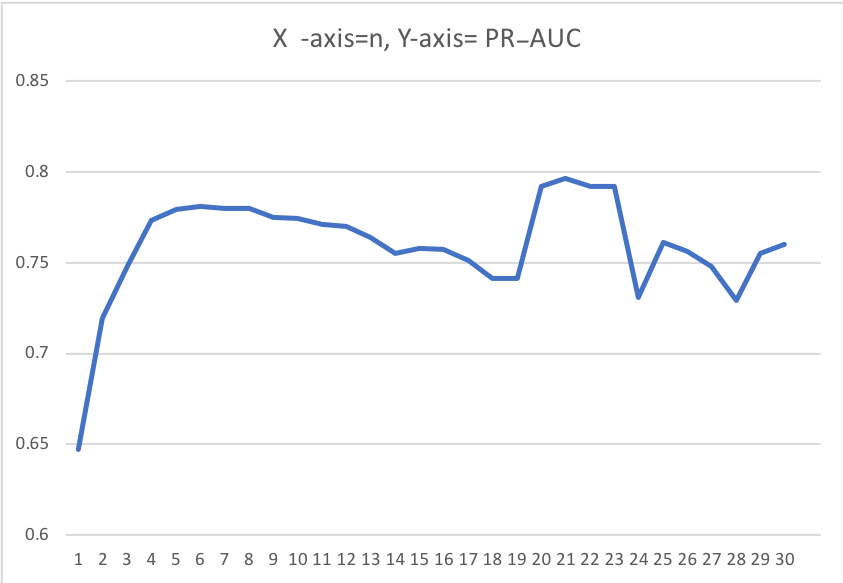
ランダムフォレストにおける特徴の数とPR-AUCの関係
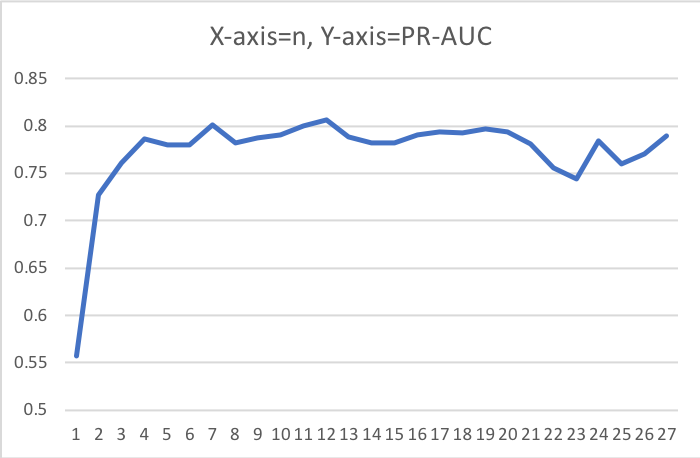

これらの図を見ると、今回の判別には特徴が上位5つ程度あれば充分だと判断できます。ロジスティック回帰において、21つも特徴を使ったときに性能が向上しているようにも見えますが、クロスバリデーションの分割の問題でたまたま数値が大きく出た可能性があります。怖いので念のために分布を見てみましょう。

In [ ]:
X, y = filter_features(19)
print(X.columns)
X, y = filter_features(20)
print(X.columns)

In [ ]:
df_masked, df0, df1 = make_dfs(X.V27,y)

for i in tqdm(range(len(df0.columns)-1)):
    g = sns.distplot(df0.iloc[:,i], color='green')
    g = sns.distplot(df1.iloc[:,i], color='red') 
    g.set_xlim(-10,10)
    plt.show()

distplotがやや崩壊してますが、どう見ても有効に働きそうな特徴の分布ではないので、やはりAUCが向上したのは分割によってたまたま起きてしまったのでしょう。
最適な変数の探索をループを回して書きましたがsklearn.model_selectionを使えばおそらく一行で書けます(多分)(調べてない)

今回のモデルを作ります。

In [ ]:
X, y = filter_features(5)
probs=[]
pr_aucs=[]
roc_aucs=[]
fprs=[]
tprs=[]
precisions=[]
recalls=[]

## cross validation
cv = StratifiedKFold(n_splits=10)

lr = LogisticRegression()
for train, test in tqdm(cv.split(X,y)): 
    ##インデックス番号の分割をしている。
    ##ロジスティック回帰
    prob = lr.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    probs.append(prob)
    ##ROC曲線
    fpr, tpr, thresholds = roc_curve(y[test], prob[:, 1], pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)
    roc_aucs.append(auc(fpr, tpr))

    ##PR曲線
    precision, recall, thresholds = precision_recall_curve(y[test], prob[:, 1], pos_label=1)
    precisions.append(precision)
    recalls.append(recall)
    pr_aucs.append(auc(recall, precision))

showCurves(recalls, precisions, fprs, tprs)
mean_recall, mean_precision, mean_fpr, mean_tpr = getMeans(recalls, precisions, fprs, tprs)
showMeanCurve(mean_recall, mean_precision, mean_fpr, mean_tpr)
